In [167]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# to handle categorical features
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [168]:
df = pd.read_csv(r"data\financial_anomaly_data.csv")
print(df.head(2))

          Timestamp TransactionID AccountID    Amount   Merchant  \
0  01-01-2023 08:00       TXN1127      ACC4  95071.92  MerchantH   
1  01-01-2023 08:01       TXN1639     ACC10  15607.89  MerchantH   

  TransactionType Location  
0        Purchase    Tokyo  
1        Purchase   London  


### Data Sanitisation

In [169]:
print(df.isnull().sum())

Timestamp          481
TransactionID      481
AccountID          481
Amount             481
Merchant           481
TransactionType    481
Location           481
dtype: int64


In [170]:
df = df.dropna()
df = df.drop_duplicates()
print(df.isnull().sum())

Timestamp          0
TransactionID      0
AccountID          0
Amount             0
Merchant           0
TransactionType    0
Location           0
dtype: int64


## Data Preprocessing

In [171]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'], format='%d-%m-%Y %H:%M')

# Sort the dataframe based on timestamp
df = df.sort_values(by='Timestamp')

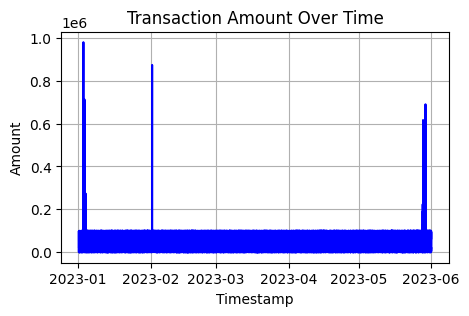

In [172]:
plt.figure(figsize=(5, 3))
plt.plot(df['Timestamp'], df['Amount'], color='blue')
plt.title('Transaction Amount Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Amount')
plt.grid(True)
plt.show()

### EDA

In [173]:
df['day_of_month'] = df['Timestamp'].dt.day
df['month'] = df['Timestamp'].dt.month
print(df.iloc[-1])

Timestamp          2023-05-31 23:59:00
TransactionID                  TXN1807
AccountID                         ACC3
Amount                        65004.99
Merchant                     MerchantG
TransactionType             Withdrawal
Location                   Los Angeles
day_of_month                        31
month                                5
Name: 216959, dtype: object


In [174]:
# Convert categorical variables into one-hot encoded features
df = pd.get_dummies(df, columns=['TransactionType', 'Location'])

In [175]:
print(df.iloc[-5:-1])

                 Timestamp TransactionID AccountID    Amount   Merchant  \
216955 2023-05-31 23:55:00       TXN1286      ACC6  62536.88  MerchantA   
216956 2023-05-31 23:56:00       TXN1015      ACC5  68629.69  MerchantG   
216957 2023-05-31 23:57:00       TXN1979     ACC15   8203.57  MerchantF   
216958 2023-05-31 23:58:00       TXN1845     ACC14  77800.36  MerchantF   

        day_of_month  month  TransactionType_Purchase  \
216955            31      5                     False   
216956            31      5                     False   
216957            31      5                      True   
216958            31      5                      True   

        TransactionType_Transfer  TransactionType_Withdrawal  Location_London  \
216955                     False                        True            False   
216956                      True                       False             True   
216957                     False                       False             True   
216958        

In [176]:
# Aggregate transaction amounts by account or merchant
# Example: Calculate total transaction amount per account
account_total_amount = df.groupby('AccountID')['Amount'].sum()
df = df.merge(account_total_amount, on='AccountID', suffixes=('', '_total'))

In [177]:
print(df.head(2))

            Timestamp TransactionID AccountID    Amount   Merchant  \
0 2023-01-01 08:00:00       TXN1127      ACC4  95071.92  MerchantH   
1 2023-01-01 08:01:00       TXN1639     ACC10  15607.89  MerchantH   

   day_of_month  month  TransactionType_Purchase  TransactionType_Transfer  \
0             1      1                      True                     False   
1             1      1                      True                     False   

   TransactionType_Withdrawal  Location_London  Location_Los Angeles  \
0                       False            False                 False   
1                       False             True                 False   

   Location_New York  Location_San Francisco  Location_Tokyo  Amount_total  
0              False                   False            True  7.173613e+08  
1              False                   False           False  7.142212e+08  


In [178]:
# Drop unnecessary columns
df.drop(['Timestamp', 'TransactionID'], axis=1, inplace=True)

## Saving new features to different csv

In [179]:
df.to_csv(r"data\processed_data.csv", index=False)

## Data preparation

In [180]:
df = pd.read_csv(r"data\processed_data.csv")

# Extract features and target
features = df.values
target = df['Amount'].values  # 'Amount' is the target variable

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False)

# Define categorical feature indices (converting catogircal to numeric to scale)
categorical_indices = [0, 2]  # 'AccountID' and 'Merchant'

# Apply one-hot encoding to categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Apply standard scaling to numeric features
numeric_transformer = Pipeline(steps=[
    # Set with_mean=False for sparse matrices
    ('scaler', StandardScaler(with_mean=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices)])

# Apply preprocessing to training and testing data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Convert the sparse array to a dense array
X_train_preprocessed = X_train_preprocessed.toarray()
X_test_preprocessed = X_test_preprocessed.toarray()

# Standard scaling
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train_preprocessed)
X_test_scaled = scaler.transform(X_test_preprocessed)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Print shapes of the tensors
print("Training data shapes:", X_train_tensor.shape, y_train_tensor.shape)
print("Testing data shapes:", X_test_tensor.shape, y_test_tensor.shape)

# Have to reshape data as per lstm
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
print("Training data shapes:", X_train_tensor.shape, y_train_tensor.shape)

Training data shapes: torch.Size([173568, 25]) torch.Size([173568])
Testing data shapes: torch.Size([43392, 25]) torch.Size([43392])
Training data shapes: torch.Size([173568, 1, 25]) torch.Size([173568])


# LSTM-based autoencoder Model

In [181]:
class Autoencoder(nn.Module):
  def __init__(self, input_size, hidden_size):
    super(Autoencoder, self).__init__()
    self.encoder = nn.LSTM(input_size, hidden_size, batch_first=True)
    self.decoder = nn.LSTM(hidden_size, input_size)

  def forward(self, x):
    # Encoder
    _, (hidden, cell) = self.encoder(x)

    # Latent representation
    # Take the last hidden state as the latent representation
    latent = hidden[-1]

    # Decoder
    # Unsqueeze to add a batch dimension
    output, _ = self.decoder(latent.unsqueeze(0))
    output = output.transpose(0, 1)

    return output


# input and hidden sizes
# Number of features in data. (after one-hot, clmn size)
input_size = num_features = 25
hidden_size = 64  # Adjust as needed

# An instance of the autoencoder model.
autoencoder = Autoencoder(input_size, hidden_size)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

## Model Training

In [182]:
# Define hyperparameters
num_epochs = 10
batch_size = 64
patience = 3  # Number of epochs to wait for improvement
min_delta = 0.0001  # Minimum change in loss to qualify as an improvement
dropout_prob = 0.2  # Dropout probability

# Create DataLoader objects for batch training
train_dataset = data.TensorDataset(X_train_tensor)
test_dataset = data.TensorDataset(X_test_tensor)
train_loader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size)

# Check if the model weights file exists
if os.path.exists('autoencoder_model.pth'):
  # Load the existing model weights
  autoencoder.load_state_dict(torch.load('autoencoder_model.pth'))
  print("Model weights loaded successfully.")
else:
  # Training loop with early stopping and model saving
  best_loss = float('inf')
  counter = 0
  for epoch in range(num_epochs):
    autoencoder.train()
    train_loss = 0.0

    for batch_idx, data in enumerate(train_loader):
      inputs = data[0]
      optimizer.zero_grad()
      outputs = autoencoder(inputs)
      loss = criterion(outputs, inputs)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()

    train_loss /= len(train_loader.dataset)

    # Validation
    autoencoder.eval()
    with torch.no_grad():
      val_loss = 0.0
      for data in test_dataset:
        inputs = data[0]
        outputs = autoencoder(inputs)
        val_loss += criterion(outputs, inputs).item()

      val_loss /= len(test_loader.dataset)

    # Early stopping
    if epoch == 0 or val_loss < best_loss - min_delta:
      best_loss = val_loss
      counter = 0
      # Save the best model
      torch.save(autoencoder.state_dict(), 'autoencoder_model.pth')
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping after {} epochs without improvement.".format(patience))
        break

    # Print training progress
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, num_epochs, train_loss, val_loss))

Model weights loaded successfully.


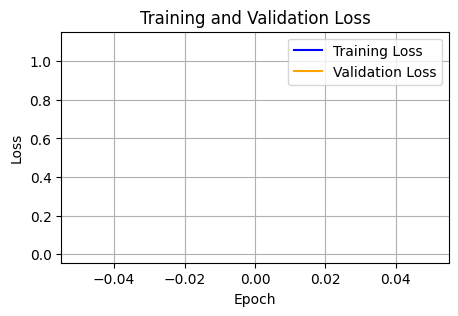

In [183]:
# Plotting the training and validation loss curves
plt.figure(figsize=(5, 3))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Testing Anomalies

In [184]:
# Load the best model
autoencoder.load_state_dict(torch.load('autoencoder_model.pth'))

# Apply the trained model to the testing dataset and compute reconstruction errors
reconstruction_errors = []
with torch.no_grad():
  autoencoder.eval()  # Set the model to evaluation mode
  for data in test_loader:
    inputs = data[0]  # Get inputs from the DataLoader
    outputs = autoencoder(inputs)
    mse_loss = criterion(outputs, inputs).item()  # Compute mean squared error
    reconstruction_errors.append(mse_loss)

# Determine a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)

# Detect anomalies based on the threshold
anomalies = [1 if error > threshold else 0 for error in reconstruction_errors]
anomalies = np.array(anomalies)

In [185]:
anomalies_indices = [np.where(anomalies == 1)[0]]  # Get indices of anomalies

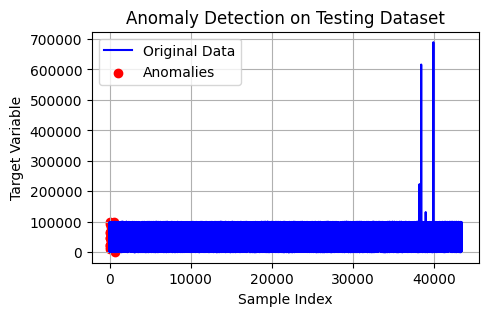

In [186]:
# Visualize anomalies in the testing dataset
plt.figure(figsize=(5, 3))
plt.plot(y_test, label='Original Data', color='blue')
plt.scatter(anomalies_indices, y_test[anomalies_indices],
            color='red', label='Anomalies', marker='o')
plt.title('Anomaly Detection on Testing Dataset')
plt.xlabel('Sample Index')
plt.ylabel('Amount')
plt.legend()
plt.grid(True)
plt.show()